### IS - PPSNA T-SNE, Robustness check and Visualization (SNA & MDS)

In [1]:
import operator
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import matplotlib.pyplot as plt
import networkx as nx

#pip install pygsp
from pygsp import graphs

In [3]:
import nltk
from nltk import bigrams
import collections

In [4]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [5]:
# Files definition
comment_past_nlp_file = 'Datasource\comment_cooc_Lift.xlsx'

In [6]:
products = ['สตรอว์เบอร์รี','ช็อกโกแลต','กาแฟ','รสหวาน','รสจืด','ไขมันต่ำ','ไขมัน 0%','ไฮโปรตีน','อัลมอนด์'
,'รสกล้วย','grass fed','นมฟรีแลคโตส','พาสเจอร์ไรส์','เมจิโกลด์','นมฮอกไกโด','เบดไทม์','ดาร์คช็อกโกแลต','ไฮแคลเซียม'
,'คาราเมล','มอลต์','เมล่อน','ชาเขียวมัจฉะ','บัลแกเรีย','โยเกิร์ต','รสธรรมชาติ','รสกลมกล่อม','โยเกิร์ต','ซากุระ','โคล่า'
,'แตงโม']

brands = ['ดัชมิลล์','เมจิ','โฟร์โมสต์','โชคชัย','แดรี่โฮม','เอ็มมิลค์','แมคโนเลีย','ไทยเดนมาร์ค','หนองโพ','คาเนชั่น','บีทาเก้น','จิตรลดา']
stores = ['tops','makro','lotus','bigc','7-Eleven']

เปิดไฟล์ที่ได้จากขั้นตอน Data Prep

In [35]:
cooc_matrix = pd.read_excel(comment_past_nlp_file,index_col=0)

In [36]:
cooc_matrix = cooc_matrix[brands]

In [40]:
cooc_matrix.head()

,ดัชมิลล์,เมจิ,โฟร์โมสต์,โชคชัย,แดรี่โฮม,เอ็มมิลค์,แมคโนเลีย,ไทยเดนมาร์ค,หนองโพ,คาเนชั่น,บีทาเก้น,จิตรลดา
เมจิ,0.107962,1.000000,0.061435,0.019004,0.004915,0.000328,0.008191,0.029325,0.032110,0.008191,0.002294,0.000000
ดัชมิลล์,1.000000,0.254440,0.188031,0.063320,0.000000,0.000772,0.000000,0.075290,0.120077,0.007722,0.003475,0.058687
แมคโนเลีย,0.000000,0.793651,0.206349,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ไทยเดนมาร์ค,0.325543,0.298831,0.470785,0.076795,0.050083,0.000000,0.000000,1.000000,0.450751,0.000000,0.000000,0.395659
หนองโพ,0.543706,0.342657,0.620629,0.321678,0.052448,0.000000,0.000000,0.472028,1.000000,0.000000,0.000000,0.295455


In [27]:
cooc_matrix.describe().stack().unstack(0)

,count,mean,std,min,25%,50%,75%,max
ดัชมิลล์,202.0,0.144228,0.136674,0.0,0.072511,0.129487,0.172414,1.0
เมจิ,202.0,0.329049,0.188751,0.0,0.220391,0.315744,0.385524,1.0
โฟร์โมสต์,202.0,0.147071,0.155883,0.0,0.061685,0.109696,0.180330,1.0
โชคชัย,202.0,0.042985,0.084996,0.0,0.000000,0.024556,0.053507,1.0
แดรี่โฮม,202.0,0.009769,0.071870,0.0,0.000000,0.000000,0.003080,1.0
เอ็มมิลค์,202.0,0.008278,0.071035,0.0,0.000000,0.000000,0.000830,1.0
แมคโนเลีย,202.0,0.009620,0.071147,0.0,0.000000,0.000000,0.002665,1.0
ไทยเดนมาร์ค,202.0,0.052641,0.100408,0.0,0.000000,0.031050,0.059215,1.0
หนองโพ,202.0,0.046707,0.094918,0.0,0.000000,0.025993,0.053715,1.0
คาเนชั่น,202.0,0.011791,0.071410,0.0,0.000000,0.000000,0.007603,1.0


สร้างกราฟ

In [10]:
def stackForGraph(cm):
    stack_matrix = pd.DataFrame(cm.stack())
    stack_matrix.index.names = ['item', 'relatedItem']
    stack_matrix.columns = ['coocValue']
    stack_matrix.reset_index(inplace=True)
    stack_matrix = stack_matrix[(stack_matrix.item != stack_matrix.relatedItem)]
    stack_matrix.sort_values(by='coocValue',ascending=False).head(10)
    return stack_matrix

In [11]:
def plot_pandas_graph(df):
    fig, ax=plt.subplots(figsize=(10,10))
    G=nx.from_pandas_edgelist(df,source='item',target='relatedItem')
    nx.draw(G,with_labels=True, font_family='Tahoma',node_color='yellow')
    plt.show()
    return G

In [12]:
def create_upperTriMatrix(df):
    df.values[np.tril(np.ones(df.shape)).astype(np.bool)] = 0
    return df

Upper matrix plot (Co-occurence without normalization)

In [41]:
#cooc_matrix_ = create_upperTriMatrix(cooc_matrix)
#cooc_matrix_2 = stackForGraph(cooc_matrix_)

cooc_matrix_2 = stackForGraph(cooc_matrix)
cooc_matrix_2_filter = cooc_matrix_2[(cooc_matrix_2.coocValue > 0)]

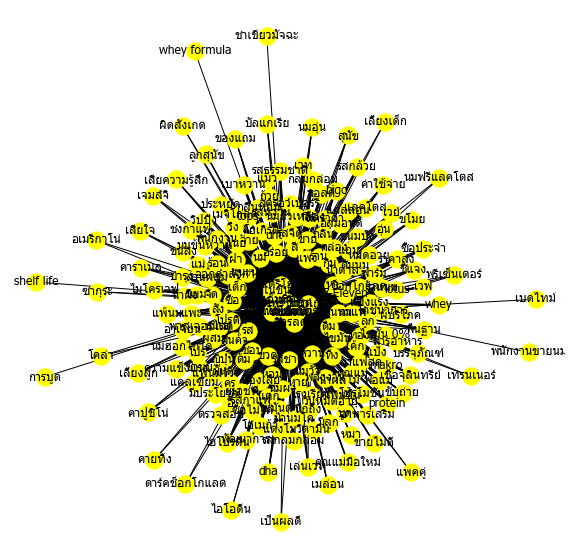

In [42]:
G2 = plot_pandas_graph(cooc_matrix_2_filter)

In [43]:
from community import community_louvain
partition = community_louvain.best_partition(G2)

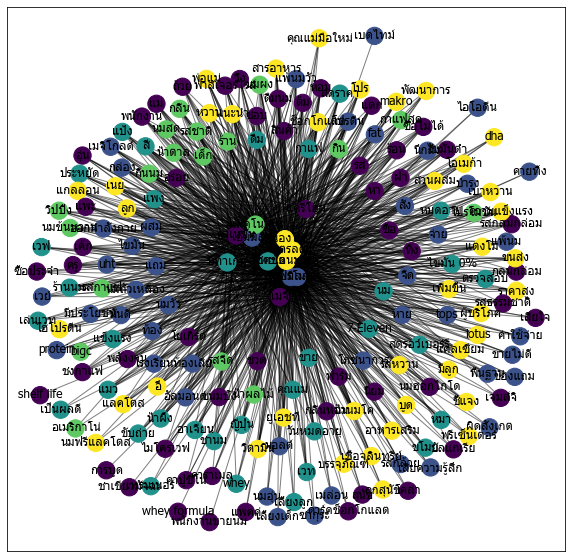

In [44]:
fig, ax=plt.subplots(figsize=(10,10))
G2=nx.from_pandas_edgelist(cooc_matrix_2_filter,source='item',target='relatedItem')
pos = nx.kamada_kawai_layout(G2)
nx.draw_networkx_nodes(G2,pos,partition.keys(),node_color=list(partition.values()))
nx.draw_networkx_edges(G2, pos, alpha=0.5)
nx.draw_networkx_labels(G2,pos,font_family='Tahoma')
plt.show()